<a href="https://colab.research.google.com/github/abubakrsiddq/ImageDehazing/blob/main/models/GCA-Net/gcaFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import random
from PIL import Image
import time
import datetime

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.optimizers import Adam

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Preprocessing and loading of data

In [3]:
#ls drive/MyDrive/reside/archive/clear_images drive/MyDrive/reside/archive/haze  

In [4]:
# function to load the image in the form of tensors.

def load_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size = (412, 548), antialias = True)
    img = img / 255.0
    return img

In [5]:
def dataset_preposses(orig_path='/content/drive/MyDrive/dataset/clear_images',haze_path='/content/drive/MyDrive/dataset/haze',percentage=0.02,validation_size=64,test_size=64,seed_val=101):
  '''
  parameters:
  orig_path(string): path of ground truth folder
  haze_path(string): path of haze folder
  percentage(float): percentage of dataset to load
  validation_size(int): the no. of validation images
  test_size(int): the no. of test images

  returns:
  haze_list,validation_list,test_list
  '''
  random.seed(seed_val)
  pth=haze_path+'/*.jpg'
  haze_path_list = glob.glob(pth)
  orig_path_list=glob.glob(orig_path+'/*.jpg')
  #print(orig_path_list)
  random.shuffle(haze_path_list)
  #print(haze_path_list)
  haze_path_dict={}
  haze_count_dict={}
  haze_list=[]
  no_per_set=int(percentage*35)
  for i in haze_path_list:
    name=i.split('/')[-1].split('_')[0]
    if(int(name)>468):
      try:
        if(haze_count_dict[name]<no_per_set):
          haze_path_dict[name].append(i)
          
          haze_count_dict[name]+=1;
          
      except KeyError:
       
        haze_path_dict[name]=[]
        haze_path_dict[name].append(i)
        haze_count_dict[name]=1
    #print(haze_path_dict)
  test_list=haze_path_list[-1*test_size:]
  val_list=haze_path_list[-1*(validation_size+test_size):-1*test_size];

  for (key,val) in haze_path_dict.items():
    for i in val:
      haze_list.append(i)
  return haze_list,val_list,test_list


def gen_dataset(ar):
  '''
  parameters
  list of paths
  return
  list with gt attached 
  '''
  orig_path='/content/drive/MyDrive/dataset/clear_images'
  haze_pth='/content/drive/MyDrive/dataset/haze'
  lst=[]
  for i in ar:
    name=i.split('/')[-1].split('_')[0]
    pthlist=[i,orig_path+'/'+name+'.jpg']
    lst.append(pthlist)
  return lst

def data_path(orig_img_path = './drive/MyDrive/reside/archive/clear_images', hazy_img_path = './drive/MyDrive/reside/archive/haze'):
  
  (a,b,c)=dataset_preposses(orig_path=orig_img_path,haze_path=hazy_img_path)
  a=gen_dataset(a)
  b=gen_dataset(b)
  return a,b

In [6]:
# function to load tensor image data in batches.

def dataloader(train_data, val_data, batch_size):
    print(len(train_data))
    train_data_orig = tf.data.Dataset.from_tensor_slices([img[1] for img in train_data]).map(lambda x: load_image(x))
    train_data_haze = tf.data.Dataset.from_tensor_slices([img[0] for img in train_data]).map(lambda x: load_image(x))
    train = tf.data.Dataset.zip((train_data_haze, train_data_orig)).shuffle(buffer_size=100).batch(batch_size)
    
    val_data_orig = tf.data.Dataset.from_tensor_slices([img[1] for img in val_data]).map(lambda x: load_image(x))
    val_data_haze = tf.data.Dataset.from_tensor_slices([img[0] for img in val_data]).map(lambda x: load_image(x))
    val = tf.data.Dataset.zip((val_data_haze, val_data_orig)).shuffle(buffer_size=100).batch(batch_size)
    
    return train, val

In [7]:
# function to display output.
import cv2
def display_img(model, hazy_img, orig_img):
    
    dehazed_img = model(hazy_img, training = True)
    plt.figure(figsize = (15,15))
    
    display_list = [hazy_img[0][:,:,:3], orig_img[0], dehazed_img[0]]
    title = ['Hazy Image', 'Ground Truth', 'Dehazed Image']
    
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')
        
    plt.show()
    #print("input image quality",display_list)#niqe(cv2.imread(display_list[1])))
    #print("input image quality",niqe(cv2.imread(display_list[2])))

# Network Function

In [120]:
class smoothDilateRes(tf.keras.Model):
  def __init__(self, channel_num, dilation=1, group=1):
        super(smoothDilateRes, self).__init__()
        #self.pre_conv1 = ShareSepConv(dilation*2-1)
        #self.conv1 = nn.Conv2d(channel_num, 3, 1, padding=dilation, dilation=dilation, groups=group, bias=False)
        self.conv1 = tf.keras.layers.Conv2D(channel_num,3,1,padding='same',dilation_rate=dilation,groups=group,use_bias=False)
        self.norm1 = tf.keras.layers.BatchNormalization()
        #self.pre_conv2 = ShareSepConv(dilation*2-1)
        self.relu= tf.keras.layers.ReLU()               

  def call(self, x):
        y=self.conv1(x)
        y=self.norm1(y)
        y=self.relu(y)
        #y = F.relu(self.norm1(self.conv1(self.pre_conv1(x))))
        y=self.conv1(x)
        y=self.norm1(y)
        y=self.relu(y)
        y = self.norm1(self.conv1(y))
        return self.relu(x+y)
        #return F.relu(x+y)

  
    

class ResBlock(tf.keras.Model):
    def __init__(self, channel_num, dilation=1, group=1):
        super(ResBlock, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(channel_num,3,1,padding='same',dilation_rate=dilation,groups=group,use_bias=False)
        self.norm1 = tf.keras.layers.BatchNormalization()
        #self.pre_conv2 = ShareSepConv(dilation*2-1)
        self.conv2 = tf.keras.layers.Conv2D(channel_num,3,1,padding='same',dilation_rate=dilation,groups=group,use_bias=False)
        self.norm2 = tf.keras.layers.BatchNormalization()
        self.relu= tf.keras.layers.ReLU()               

    def call(self, x):
        y = self.relu(self.norm1(self.conv1(x)))
        y = self.norm1(self.conv2(y))
        return self.relu(x+y)

In [121]:

class GCA(tf.keras.Model):
    def __init__(self, in_c=4, out_c=3, only_residual=True):
        super(GCA, self).__init__()
        #self.relu1= tf.keras.layers.ReLU()
        
        self.conv1 = tf.keras.layers.Conv2D(64,3,strides=1,padding='same',use_bias=False,activation='relu')             
        self.norm1 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv2D(64,3,strides=1,padding='same',use_bias=False,activation='relu')
        self.norm2 = tf.keras.layers.BatchNormalization()
        self.conv3 = tf.keras.layers.Conv2D(64,3,strides=2,padding='same',use_bias=False,activation='relu')
        self.norm3 = tf.keras.layers.BatchNormalization()
        self.res1 = smoothDilateRes(64, dilation=2)
        self.res2 = smoothDilateRes(64, dilation=2)
        self.res3 = smoothDilateRes(64, dilation=2)
        self.res4 = smoothDilateRes(64, dilation=4)
        self.res5 = smoothDilateRes(64, dilation=4)
        self.res6 = smoothDilateRes(64, dilation=4)
        self.res7 = ResBlock(64, dilation=1)

        self.gate = tf.keras.layers.Conv2D(3,3,1,padding='same',use_bias=True,activation='relu')
        #nn.ConvTranspose2d(64, 64, 4, 2, 1)
        self.deconv3 =tf.keras.layers.Conv2DTranspose(64,4,2,padding='same',activation='relu')
        self.norm4 = tf.keras.layers.BatchNormalization()
        self.deconv2 =tf.keras.layers.Conv2DTranspose(64,3,1,padding='same',activation='relu') 
        self.norm5 = tf.keras.layers.BatchNormalization()
        #nn.Conv2d(64, 64, 3, 1, 1)
        self.deconv1 =tf.keras.layers.Conv2DTranspose(out_c,1,activation='relu')
        self.only_residual = only_residual
        
       
    def call(self, input_tensor, training=False):
       
        y = self.norm1(self.conv1(input_tensor))
        y = self.norm2(self.conv2(y))   
        y1= self.norm3(self.conv3(y))
        
        y = self.res1(y1)
        y = self.res2(y)
        y = self.res3(y)
        y2 = self.res4(y)
        y = self.res5(y2)
        y = self.res6(y)
        y3 = self.res7(y)
        #gates = self.gate(torch.cat((y1, y2, y3), dim=1))
       
        
        #g=tf.keras.layers.Concatenate(axis=-1)([y1, y2,y3])
        gates = self.gate(tf.keras.layers.Concatenate(axis=-1)([y1, y2,y3]))
        #return gates
        g1=tf.expand_dims(gates[:,:,:,0],-1)
        g2=tf.expand_dims(gates[:,:,:,1],-1)
        g3=tf.expand_dims(gates[:,:,:,2],-1)
        gated_y = g1*y1+g2*y2+g3*y3
        y = self.norm4(self.deconv3(gated_y))
       
        y = self.norm5(self.deconv2(y))
        if self.only_residual:
            y = self.deconv1(y)
        else:
            y = self.deconv1(y)
            #y = self.relu1(self.deconv1(y))

        return y
        

    def model(self):
        x = Input(shape = (412, 548, 4))
        return Model(inputs=[x], outputs=self.call(x))

    
    def build_graph(self):
        x = Input(shape=(412, 548, 4))
        return Model(inputs=[x], outputs=self.call(x))


Model: "model_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           [(None, 412, 548, 4) 0                                            
__________________________________________________________________________________________________
conv2d_155 (Conv2D)             (None, 412, 548, 64) 2304        input_24[0][0]                   
__________________________________________________________________________________________________
batch_normalization_150 (BatchN (None, 412, 548, 64) 256         conv2d_155[0][0]                 
__________________________________________________________________________________________________
conv2d_156 (Conv2D)             (None, 412, 548, 64) 36864       batch_normalization_150[0][0]    
___________________________________________________________________________________________

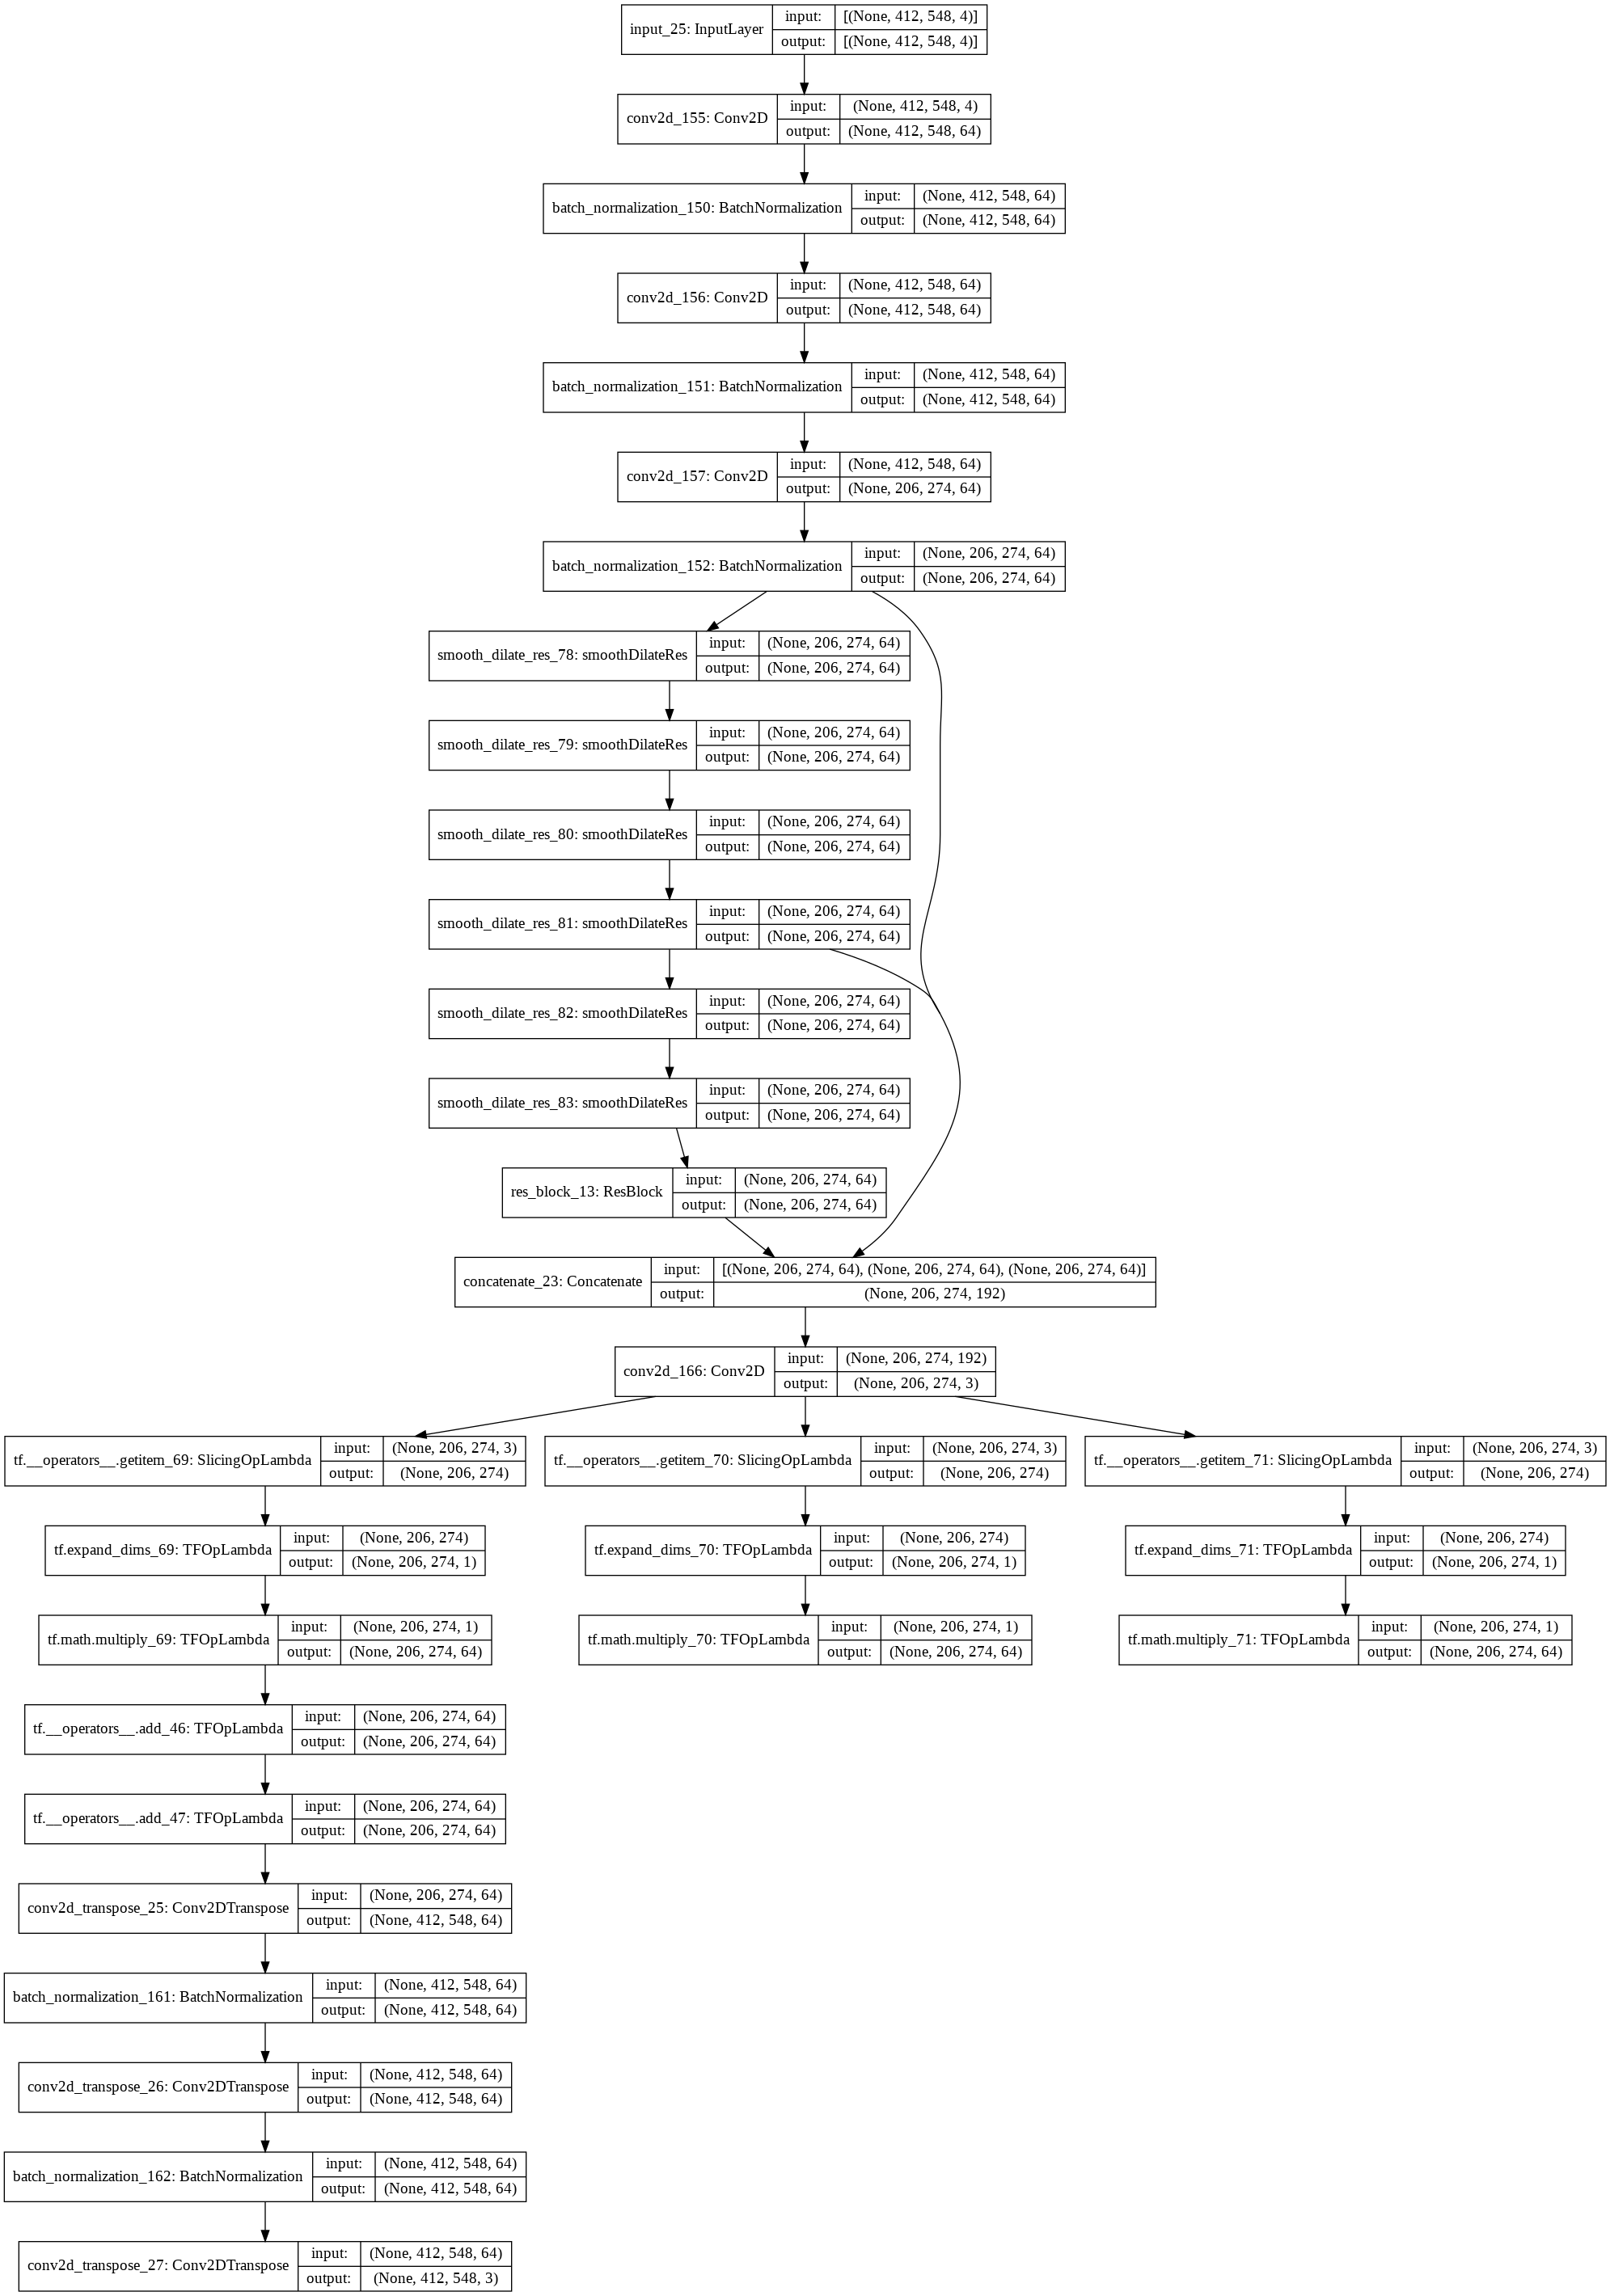

In [122]:
sub = GCA()
sub.model().summary()
dot_img_file = '/tmp/model_1.png'
tf.keras.utils.plot_model(
    sub.build_graph(),                      # here is the trick (for now)
    to_file='model.png', dpi=96,              # saving  
    show_shapes=True, show_layer_names=True,  # show shapes and layer name
    expand_nested=True                      # will show nested block
)


In [70]:
import torch
pretrain=torch.load('./wacv_gcanet_dehaze.pth',map_location=torch.device('cpu'))
pretrain.keys()

odict_keys(['conv1.weight', 'norm1.weight', 'norm1.bias', 'conv2.weight', 'norm2.weight', 'norm2.bias', 'conv3.weight', 'norm3.weight', 'norm3.bias', 'res1.pre_conv1.weight', 'res1.conv1.weight', 'res1.norm1.weight', 'res1.norm1.bias', 'res1.pre_conv2.weight', 'res1.conv2.weight', 'res1.norm2.weight', 'res1.norm2.bias', 'res2.pre_conv1.weight', 'res2.conv1.weight', 'res2.norm1.weight', 'res2.norm1.bias', 'res2.pre_conv2.weight', 'res2.conv2.weight', 'res2.norm2.weight', 'res2.norm2.bias', 'res3.pre_conv1.weight', 'res3.conv1.weight', 'res3.norm1.weight', 'res3.norm1.bias', 'res3.pre_conv2.weight', 'res3.conv2.weight', 'res3.norm2.weight', 'res3.norm2.bias', 'res4.pre_conv1.weight', 'res4.conv1.weight', 'res4.norm1.weight', 'res4.norm1.bias', 'res4.pre_conv2.weight', 'res4.conv2.weight', 'res4.norm2.weight', 'res4.norm2.bias', 'res5.pre_conv1.weight', 'res5.conv1.weight', 'res5.norm1.weight', 'res5.norm1.bias', 'res5.pre_conv2.weight', 'res5.conv2.weight', 'res5.norm2.weight', 'res5.nor

In [123]:
sub.load_weights('/content/drive/MyDrive/nets/gca/weights')

In [147]:
sub.layers

In [141]:
sub.layers[12].layers[2].get_weights()[0].shape

(3, 3, 64, 64)

In [142]:
pretrain['res7.conv2.weight'].shape

torch.Size([64, 64, 3, 3])

In [143]:
w=np.moveaxis(pretrain['res7.conv2.weight'].numpy(),(0,1),(-1,-2))
#b=pretrain['deconv1.bias'].numpy()

In [144]:
l=[w]
#sub.layers[-1].set_weights(l)
sub.layers[12].layers[2].set_weights(l)

In [145]:
sub.save_weights('/content/drive/MyDrive/nets/gca/weights')

In [40]:
# Hyperparameters
epochs = 1
batch_size = 4
k_init = tf.keras.initializers.random_normal(stddev=0.008, seed = 101)      
regularizer = tf.keras.regularizers.L2(1e-4)
b_init = tf.constant_initializer()

#train_data, val_data = data_path(orig_img_path = './drive/MyDrive/reside/archive/clear_images', hazy_img_path = './drive/MyDrive/reside/archive/haze')
train_data, val_data = data_path(orig_img_path = './drive/MyDrive/dataset/clear_images', hazy_img_path = './drive/MyDrive/dataset/haze')
train, val = dataloader(train_data, val_data, batch_size)

optimizer = Adam(learning_rate = 1e-4)
net = GCA()
#net.load_weights('/content/drive/MyDrive/nets/gca/weights')
#net= tf.keras.models.load_model('/content/drive/MyDrive/nets/gca',compile=False)
train_loss_tracker = tf.keras.metrics.MeanSquaredError(name = "train loss")
val_loss_tracker = tf.keras.metrics.MeanSquaredError(name = "val loss")

372


In [41]:
def train_model(epochs, train, val, net, train_loss_tracker, val_loss_tracker, optimizer):
    
    for epoch in range(epochs):
        
        print("\nStart of epoch %d" % (epoch,), end=' ')
        start_time_epoch = time.time()
        start_time_step = time.time()
        
        # training loop
        
        for step, (train_batch_haze, train_batch_orig) in enumerate(train):

            with tf.GradientTape() as tape:
                y=tf.image.sobel_edges(train_batch_haze)
                y=tf.reduce_sum(y,axis=-1)
                y=tf.reduce_mean(y,-1,keepdims=True)
                train_batch_haze=tf.concat([train_batch_haze,y],axis=-1)
                #print(train_batch_haze.shape)
                train_logits = net(train_batch_haze, training = True)
                #print(train_logits.shape)
                loss = mean_squared_error(train_batch_orig, train_logits)

            grads = tape.gradient(loss, net.trainable_weights)
            optimizer.apply_gradients(zip(grads, net.trainable_weights))

            train_loss_tracker.update_state(train_batch_orig, train_logits)
            if step == 0:
                print('[', end='')
            if step % 64 == 0:
                print('=', end='')
        
        print(']', end='')
        print('  -  ', end='')
        print('Training Loss: %.4f' % (train_loss_tracker.result()), end='')
        
        # validation loop
        
        for step, (val_batch_haze, val_batch_orig) in enumerate(val):
            y=tf.image.sobel_edges(val_batch_haze)
            y=tf.reduce_sum(y,axis=-1)
            y=tf.reduce_mean(y,-1,keepdims=True)
            val_batch_haze=tf.concat([val_batch_haze,y],axis=-1)
            val_logits = net(val_batch_haze, training = False)
            val_loss_tracker.update_state(val_batch_orig, val_logits)
            
            if step % 32 ==0:
                display_img(net, val_batch_haze, val_batch_orig)
        
        print('  -  ', end='')
        print('Validation Loss: %.4f' % (val_loss_tracker.result()), end='')
        print('  -  ', end=' ')
        print("Time taken: %.2fs" % (time.time() - start_time_epoch))
        
        net.save('trained_model')           # save the model(variables, weights, etc)
        train_loss_tracker.reset_states()
        val_loss_tracker.reset_states()


Start of epoch 0 (4, 412, 548, 4)
[=(4, 412, 548, 4)
(4, 412, 548, 4)
(4, 412, 548, 4)
(4, 412, 548, 4)
(4, 412, 548, 4)
(4, 412, 548, 4)
(4, 412, 548, 4)
(4, 412, 548, 4)
(4, 412, 548, 4)
(4, 412, 548, 4)
(4, 412, 548, 4)
(4, 412, 548, 4)
(4, 412, 548, 4)
(4, 412, 548, 4)
(4, 412, 548, 4)
(4, 412, 548, 4)
(4, 412, 548, 4)
(4, 412, 548, 4)
(4, 412, 548, 4)
(4, 412, 548, 4)
(4, 412, 548, 4)
(4, 412, 548, 4)
(4, 412, 548, 4)
(4, 412, 548, 4)
(4, 412, 548, 4)
(4, 412, 548, 4)
(4, 412, 548, 4)
(4, 412, 548, 4)
(4, 412, 548, 4)
(4, 412, 548, 4)
(4, 412, 548, 4)
(4, 412, 548, 4)
(4, 412, 548, 4)
(4, 412, 548, 4)
(4, 412, 548, 4)
(4, 412, 548, 4)
(4, 412, 548, 4)
(4, 412, 548, 4)
(4, 412, 548, 4)
(4, 412, 548, 4)
(4, 412, 548, 4)
(4, 412, 548, 4)
(4, 412, 548, 4)
(4, 412, 548, 4)
(4, 412, 548, 4)
(4, 412, 548, 4)
(4, 412, 548, 4)
(4, 412, 548, 4)
(4, 412, 548, 4)
(4, 412, 548, 4)
(4, 412, 548, 4)
(4, 412, 548, 4)
(4, 412, 548, 4)
(4, 412, 548, 4)
(4, 412, 548, 4)
(4, 412, 548, 4)
(4, 412, 54

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


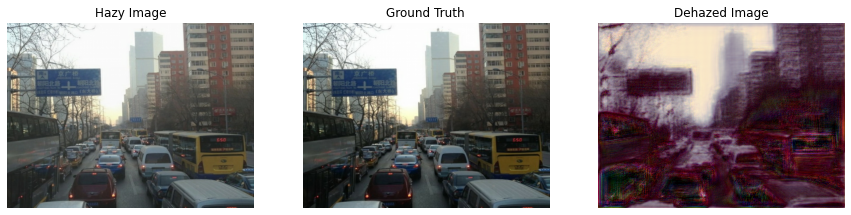

  -  Validation Loss: 0.2479  -   Time taken: 178.14s
INFO:tensorflow:Assets written to: trained_model/assets
CPU times: user 1min 13s, sys: 36.3 s, total: 1min 49s
Wall time: 3min 9s


In [42]:
%%time
train_model(epochs, train, val, net, train_loss_tracker, val_loss_tracker, optimizer)

In [67]:
#net.save('/content/drive/MyDrive/nets/gca')

#sub.save_weights('/content/drive/MyDrive/nets/gca/weights')
#model=net

#model.model().summary()


In [ ]:
import cv2
import matplotlib.pyplot as plt

def evaluate_gen(net):
    
    #test_img = glob.glob(test_img_path +'/*.jpg')
    test_img=glob.glob('/content/drive/MyDrive/Final_compare/HAZY/*.jpg')
    #random.shuffle(test_img)
    i=0;
    for img in test_img:
        print(img)
        img = tf.io.read_file(img)
        img = tf.io.decode_jpeg(img, channels = 3)
        
        img = tf.image.resize(img, size = (412,548), antialias = True)
        
        img = img / 255.0
        print(i,end=" ")
        img = tf.expand_dims(img, axis = 0)      #transform input image from 3D to 4D ###
        
        dehaze =net(img, training = True)
        dehaze=tf.image.resize(dehaze, size = (413,550), antialias = True)
        #plt.figure(figsize = (80, 80))
        
        #display_list = [img[0], dehaze[0]]       #make the first dimension zero
        im=dehaze[0]
        directory = '/content/drive/MyDrive/Final_compare/gca'
        os.chdir(directory)
        filename = str(i) + '_outdoor_gen.jpg'
        #print(filename)
        #cv2.imwrite(filename,im) 
        #plt.imsave(filename,im)
        tf.keras.preprocessing.image.save_img(
    filename, 

im)

        os.chdir('/content')
        i+=1;

In [ ]:
#new_model = tf.keras.models.load_model('/content/drive/MyDrive/nets/gca',compile=False)
#new_model = tf.keras.models.load_model('/content/drive/MyDrive/nets/gca/trained_model',compile=False)
#new_model = tf.keras.models.load_model('/content/drive/MyDrive/nets/test_custom_loss_net',compile=False)


#evaluate_gen(new_model)
evaluate_gen(net)

/content/drive/MyDrive/Final_compare/HAZY/0_outdoor_hazy.jpg
0 /content/drive/MyDrive/Final_compare/HAZY/4_outdoor_hazy.jpg
1 /content/drive/MyDrive/Final_compare/HAZY/2_outdoor_hazy.jpg
2 /content/drive/MyDrive/Final_compare/HAZY/5_outdoor_hazy.jpg
3 /content/drive/MyDrive/Final_compare/HAZY/3_outdoor_hazy.jpg
4 /content/drive/MyDrive/Final_compare/HAZY/1_outdoor_hazy.jpg
5 /content/drive/MyDrive/Final_compare/HAZY/6_outdoor_hazy.jpg
6 /content/drive/MyDrive/Final_compare/HAZY/7_outdoor_hazy.jpg
7 /content/drive/MyDrive/Final_compare/HAZY/8_outdoor_hazy.jpg
8 /content/drive/MyDrive/Final_compare/HAZY/9_outdoor_hazy.jpg
9 /content/drive/MyDrive/Final_compare/HAZY/10_outdoor_hazy.jpg
10 /content/drive/MyDrive/Final_compare/HAZY/11_outdoor_hazy.jpg
11 /content/drive/MyDrive/Final_compare/HAZY/12_outdoor_hazy.jpg
12 /content/drive/MyDrive/Final_compare/HAZY/13_outdoor_hazy.jpg
13 /content/drive/MyDrive/Final_compare/HAZY/14_outdoor_hazy.jpg
14 /content/drive/MyDrive/Final_compare/HAZY/15_

In [ ]:
cp -r trained_model/ /content/drive/MyDrive/nets/gca/trained_model

In [32]:

import torch
import torch.nn as nn
import torch.nn.functional as F


class ShareSepConv(nn.Module):
    def __init__(self, kernel_size):
        super(ShareSepConv, self).__init__()
        assert kernel_size % 2 == 1, 'kernel size should be odd'
        self.padding = (kernel_size - 1)//2
        weight_tensor = torch.zeros(1, 1, kernel_size, kernel_size)
        weight_tensor[0, 0, (kernel_size-1)//2, (kernel_size-1)//2] = 1
        self.weight = nn.Parameter(weight_tensor)
        self.kernel_size = kernel_size

    def forward(self, x):
        inc = x.size(1)
        expand_weight = self.weight.expand(inc, 1, self.kernel_size, self.kernel_size).contiguous()
        return F.conv2d(x, expand_weight,
                        None, 1, self.padding, 1, inc)


class SmoothDilatedResidualBlock(nn.Module):
    def __init__(self, channel_num, dilation=1, group=1):
        super(SmoothDilatedResidualBlock, self).__init__()
        self.pre_conv1 = ShareSepConv(dilation*2-1)
        self.conv1 = nn.Conv2d(channel_num, channel_num, 3, 1, padding=dilation, dilation=dilation, groups=group, bias=False)
        self.norm1 = nn.InstanceNorm2d(channel_num, affine=True)
        self.pre_conv2 = ShareSepConv(dilation*2-1)
        self.conv2 = nn.Conv2d(channel_num, channel_num, 3, 1, padding=dilation, dilation=dilation, groups=group, bias=False)
        self.norm2 = nn.InstanceNorm2d(channel_num, affine=True)

    def forward(self, x):
        y = F.relu(self.norm1(self.conv1(self.pre_conv1(x))))
        y = self.norm2(self.conv2(self.pre_conv2(y)))
        return F.relu(x+y)


class ResidualBlock(nn.Module):
    def __init__(self, channel_num, dilation=1, group=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channel_num, channel_num, 3, 1, padding=dilation, dilation=dilation, groups=group, bias=False)
        self.norm1 = nn.InstanceNorm2d(channel_num, affine=True)
        self.conv2 = nn.Conv2d(channel_num, channel_num, 3, 1, padding=dilation, dilation=dilation, groups=group, bias=False)
        self.norm2 = nn.InstanceNorm2d(channel_num, affine=True)

    def forward(self, x):
        y = F.relu(self.norm1(self.conv1(x)))
        y = self.norm2(self.conv2(y))
        return F.relu(x+y)


class GCANet(nn.Module):
    def __init__(self, in_c=4, out_c=3, only_residual=True):
        super(GCANet, self).__init__()
        self.conv1 = nn.Conv2d(in_c, 64, 3, 1, 1, bias=False)
        self.norm1 = nn.InstanceNorm2d(64, affine=True)
        self.conv2 = nn.Conv2d(64, 64, 3, 1, 1, bias=False)
        self.norm2 = nn.InstanceNorm2d(64, affine=True)
        self.conv3 = nn.Conv2d(64, 64, 3, 2, 1, bias=False)
        self.norm3 = nn.InstanceNorm2d(64, affine=True)

        self.res1 = SmoothDilatedResidualBlock(64, dilation=2)
        self.res2 = SmoothDilatedResidualBlock(64, dilation=2)
        self.res3 = SmoothDilatedResidualBlock(64, dilation=2)
        self.res4 = SmoothDilatedResidualBlock(64, dilation=4)
        self.res5 = SmoothDilatedResidualBlock(64, dilation=4)
        self.res6 = SmoothDilatedResidualBlock(64, dilation=4)
        self.res7 = ResidualBlock(64, dilation=1)

        self.gate = nn.Conv2d(64 * 3, 3, 3, 1, 1, bias=True)

        self.deconv3 = nn.ConvTranspose2d(64, 64, 4, 2, 1)
        self.norm4 = nn.InstanceNorm2d(64, affine=True)
        self.deconv2 = nn.Conv2d(64, 64, 3, 1, 1)
        self.norm5 = nn.InstanceNorm2d(64, affine=True)
        self.deconv1 = nn.Conv2d(64, out_c, 1)
        self.only_residual = only_residual

    def forward(self, x):
        y = F.relu(self.norm1(self.conv1(x)))
        y = F.relu(self.norm2(self.conv2(y)))
        y1 = F.relu(self.norm3(self.conv3(y)))

        y = self.res1(y1)
        y = self.res2(y)
        y = self.res3(y)
        y2 = self.res4(y)
        y = self.res5(y2)
        y = self.res6(y)
        y3 = self.res7(y)

        gates = self.gate(torch.cat((y1, y2, y3), dim=1))
        gated_y = y1 * gates[:, [0], :, :] + y2 * gates[:, [1], :, :] + y3 * gates[:, [2], :, :]
        y = F.relu(self.norm4(self.deconv3(gated_y)))
        y = F.relu(self.norm5(self.deconv2(y)))
        if self.only_residual:
            y = self.deconv1(y)
        else:
            y = F.relu(self.deconv1(y))

        return y

In [33]:
from torchsummary import summary
net=GCANet()
if torch.cuda.is_available():
    net.cuda()
print(summary(net, (3, 412, 548)))

RuntimeError: ignored